In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import koreanize_matplotlib
import seaborn as sns
import requests, json

random_state = 412

# EDA Functions
# hard coding for unique print
columns_for_unique_print = ["Age", "Gender", "Car_number", "Car_model", "Fuel", "Start_spot_ID", "End_spot_ID"]

def print_unique(df):
    ''' cat variable의 unique 출력 함수'''
    for col in columns_for_unique_print:
        n = df[col].nunique()
        print(f"{col}: {n}개")

        # n이 30개 미만인 경우에만 출력
        if n < 30:
            print(df[col].unique())
        print()

# 출발 스팟 ID별 분석
spot_id_name = {}

def get_spot_name(spot_id):
    spot_id = str(spot_id)
    if spot_id in spot_id_name:
        return spot_id_name[spot_id]
    else:
        return "Unknown"


def print_top10_spot(df, col, designated = True, non_designated = True):
    if designated:
        if non_designated:
            df_user = df
            file_name = "전체_사용자"
        else:
            df_user = df[df["Target"]]
            file_name = "대리운전기사"
    else: 
        df_user = df[~df["Target"]]
        file_name = "일반사용자"

    df_spot_out_count = df_user[col].value_counts()
    high_index = df_spot_out_count.index[:10]
    spot_id_name_high = {k: v for k, v in spot_id_name.items() if k in high_index}
    spot_id_name_high
    
    print(f"{file_name} 출발 스팟 ID TOP 10: ")
    print(spot_id_name_high)


def plot_count_datetime(df, designated = True, non_designated = True):
    '''
    이용날짜, 시간대별 count plot
    designated: 대리운전기사인 경우 포함
    non_designated: 대리운전기사가 아닌 경우(일반 사용자) 포함
    
    default setting : 모든 user 포함
    '''

    if designated:
        if non_designated:
            df_user = df
            file_name = "전체_사용자"
        else:
            df_user = df[df["Target"]]
            file_name = "대리운전기사"
    else: 
        df_user = df[~df["Target"]]
        file_name = "일반사용자"


    fig, ax = plt.subplots(2, 3, figsize=(16, 8))

    df_user["End_date"].dt.hour.hist(bins=24, ax=ax[0, 0])
    ax[0, 0].set_title("반납 기준 시간대별 이용 내역")

    df_user["End_date"].dt.month.value_counts().sort_index().plot(kind="bar", ax=ax[0, 1])
    ax[0, 1].set_title("반납 기준 월별 이용 내역")

    df_user["End_date"].dt.date.value_counts().sort_index().plot(ax=ax[0, 2])
    ax[0, 2].set_title("반납 기준 일별 이용 내역")

    # 요일별로 이용 내역 count
    df_user["End_date"].dt.dayofweek.value_counts().sort_index().plot(kind="bar", ax=ax[1, 0])
    ax[1, 0].set_title("반납 기준 요일별 이용 내역")

    df_user["User_ID"].value_counts().plot(kind="box", ax=ax[1, 1])
    ax[1, 1].set_title("고객별 이용 count")

    df_user.groupby("User_ID")["Total_time"].sum().plot(kind="box", ax=ax[1, 2])
    ax[1, 2].set_title("고객별 총 이용시간")

    plt.tight_layout()

    # check if output directory exists
    if not os.path.exists("output"):
        print("output directory does not exist. Creating output directory")
        os.makedirs("output")

    # save figure
    plt.savefig(f"output/{file_name}.png")



# folium heat map
def heatmap_spot(df_user, col_name = "Start"):
    if col_name == "Start":
        x = "Start_spot_x"
        y = "Start_spot_y"
    else: 
        x = "End_spot_x"
        y = "End_spot_y"

    m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
    heat_df = df_user[[x, y]]

    heat_data = [[row[y], row[x]] for index, row in heat_df.iterrows()]
    HeatMap(heat_data).add_to(m)
    
    return m


In [2]:
with open("output/spot_id_name.json", "r") as f:
    spot_id_name = json.load(f)

df_user = pd.read_csv("output/주제2_사용자데이터_전처리_V2.csv")
df_user["Start_date"] = pd.to_datetime(df_user["Start_date"])
df_user["End_date"] = pd.to_datetime(df_user["End_date"])

df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13420 entries, 0 to 13419
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   User_ID          13420 non-null  object        
 1   Age              13420 non-null  int64         
 2   Gender           13420 non-null  object        
 3   Car_number       13420 non-null  object        
 4   Car_model        13420 non-null  object        
 5   Fuel             13420 non-null  object        
 6   Start_spot_ID    13420 non-null  int64         
 7   Start_spot_name  13420 non-null  object        
 8   Start_spot_addr  13420 non-null  object        
 9   End_spot_ID      13420 non-null  int64         
 10  End_spot_name    13420 non-null  object        
 11  End_spot_addr    13420 non-null  object        
 12  Start_date       13420 non-null  datetime64[ns]
 13  End_date         13420 non-null  datetime64[ns]
 14  Total_time       13420 non-null  int64

Eigenvector_centrality : 
> Eigenvector Centrality는 어떤 노드가 중요한 노드에 연결되었는가를 판단하고, weight를 반영할 수 있다.
>
> Eigenvector Centrality는 이웃 노드가 갖고 있는 특정한 값들에 기반을 두기 때문에 degree, betweeness, closeness 등의 지표를 Generalization 한 것이라 여길 수 있다
> 
> 시간복잡도: $O(V^3)$

In [3]:
import networkx as nx
# Clustering spot_id or find communities
# spot_id별로 이용 count
# for only Target User
df_user_target = df_user[df_user["Target"]==1]
df_user_non_target = df_user[df_user["Target"]==0]

df_spot_out_count = df_user_target["Start_spot_ID"].value_counts()
df_spot_in_count = df_user_target["End_spot_ID"].value_counts()

df_spot_pair_cnt = df_user_target[["Start_spot_ID", "End_spot_ID"]].value_counts().reset_index()
df_spot_pair_cnt.columns = ["Start_spot_ID", "End_spot_ID", "Count"]
df_spot_pair_cnt = df_spot_pair_cnt.sort_values("Count", ascending=False)


# spot_id별로 이용 count를 dictionary로 변환
spot_out_count = df_spot_out_count.to_dict()
spot_in_count = df_spot_in_count.to_dict()

G = nx.DiGraph()

# spot_id별로 이용 count를 node의 attribute로 추가
nx.set_node_attributes(G, spot_out_count, "out_count")
nx.set_node_attributes(G, spot_in_count, "in_count")

# spot_id pair별로 이용 count를 edge의 attribute로 추가
for idx, row in df_spot_pair_cnt.iterrows():
    G.add_edge(row["Start_spot_ID"], row["End_spot_ID"], weight=row["Count"])

# spot_id별로 이용 count가 높은 순서대로 정렬
sorted_spot_out_count = sorted(spot_out_count.items(), key=lambda x: x[1], reverse=True)

# Calculate EigenVector Centrality
# eigenvector_centrality = nx.eigenvector_centrality(G, max_iter = 1000,  weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter = 1000,  weight='weight')

# scaling eigenvector centrality
max_value = max(eigenvector_centrality.values())
min_value = min(eigenvector_centrality.values())
eigenvector_centrality = {k: (v - min_value) / (max_value - min_value) for k, v in eigenvector_centrality.items()}

# eigenvector centrality를 dataframe으로 변환
df_ec = pd.DataFrame(eigenvector_centrality.items(), columns=["Spot_ID", "Eigenvector_centrality"])

df_ec.sort_values("Eigenvector_centrality", ascending=False, inplace=True)
df_ec.reset_index(drop=True, inplace=True)

display(df_ec.head())

DiGraph with 360 nodes and 2700 edges


In [5]:
# Top 5 spot_id

for i in range(5):
    spot_id = df_ec.loc[i, "Spot_ID"]
    print(f"Spot ID: {spot_id}, Eigenvector Centrality: {df_ec.loc[i, 'Eigenvector_centrality']}")
    print(f"Spot Name: {get_spot_name(spot_id)}")
    print()

Spot ID: 231, Eigenvector Centrality: 1.0
Spot Name: 인천신현파크프라자 지상8층(옥상)

Spot ID: 52, Eigenvector Centrality: 0.8062133887330438
Spot Name: 논현3호주차장(라온제나) 지상5층

Spot ID: 51, Eigenvector Centrality: 0.6803439675539243
Spot Name: 논현웰스톤 지하5층

Spot ID: 238, Eigenvector Centrality: 0.6388670443699566
Spot Name: 메가스타영종 지하3층

Spot ID: 315, Eigenvector Centrality: 0.5875029573906115
Spot Name: 신월동방숯가마사우나 지상주차장



In [ ]:
df_user_target_spot = df_user_target["End_spot_ID"].value_counts().sort_values(ascending=False).reset_index()
df_user_non_target_spot = df_user_non_target["End_spot_ID"].value_counts().sort_values(ascending=False).reset_index()

대리운전기사가 자주 방문하는 Spot_ID 는 Centrality가 높고, 일반 사용자가 자주 방문하는 Spot_ID는 Centrality가 낮은 것 파악 가능

In [7]:
display(df_ec[df_ec["Spot_ID"].isin(df_user_target_spot.iloc[:10, 0].values)])
display(df_ec[df_ec["Spot_ID"].isin(df_user_non_target_spot.iloc[:10, 0].values)])

,Spot_ID,Eigenvector_centrality
0,231,1.000000
1,52,0.806213
2,51,0.680344
7,81,0.490519
10,164,0.464142
14,61,0.390143
15,203,0.385061
20,278,0.321235
25,109,0.260149
28,38,0.233585


,Spot_ID,Eigenvector_centrality
1,52,0.806213
3,238,0.638867
6,153,0.515936
12,254,0.408109
69,148,0.081395
77,222,0.062025
85,154,0.054030
147,28,0.009758
161,13,0.006029
325,99,0.000000


In [10]:
spot_id_address_xy = pd.read_csv("output/spot_id_address_xy.csv")

df_ec = df_ec.merge(spot_id_address_xy, left_on="Spot_ID", right_on="spot_id", how="left")
df_ec = df_ec[['spot_id', 'Eigenvector_centrality', 'x', 'y']]
df_ec.to_csv("output/spot_id_eigenvector_centrality.csv", index=False)

display(df_ec.head())

,spot_id,Eigenvector_centrality,x,y
0,231,1.000000,126.702230,37.445136
1,52,0.806213,127.038589,37.516963
2,51,0.680344,127.038023,37.518458
3,238,0.638867,126.491490,37.493421
4,315,0.587503,126.846604,37.521350


In [12]:
df_target_end_spot = df_user_target["End_spot_ID"].value_counts().reset_index()
df_target_end_spot = df_target_end_spot.merge(spot_id_address_xy, left_on="End_spot_ID", right_on="spot_id", how="left")
df_target_end_spot.head()

,End_spot_ID,count,spot_id,address,x,y
0,231,202,231,인천광역시 남동구 성말로 16,126.702230,37.445136
1,52,169,52,서울특별시 강남구 학동로47길 5,127.038589,37.516963
2,51,110,51,서울특별시 강남구 학동로43길 38,127.038023,37.518458
3,203,106,203,서울특별시 강남구 봉은사로 125,127.027426,37.505760
4,164,92,164,경기도 의정부시 천보로 44,127.096321,37.744314


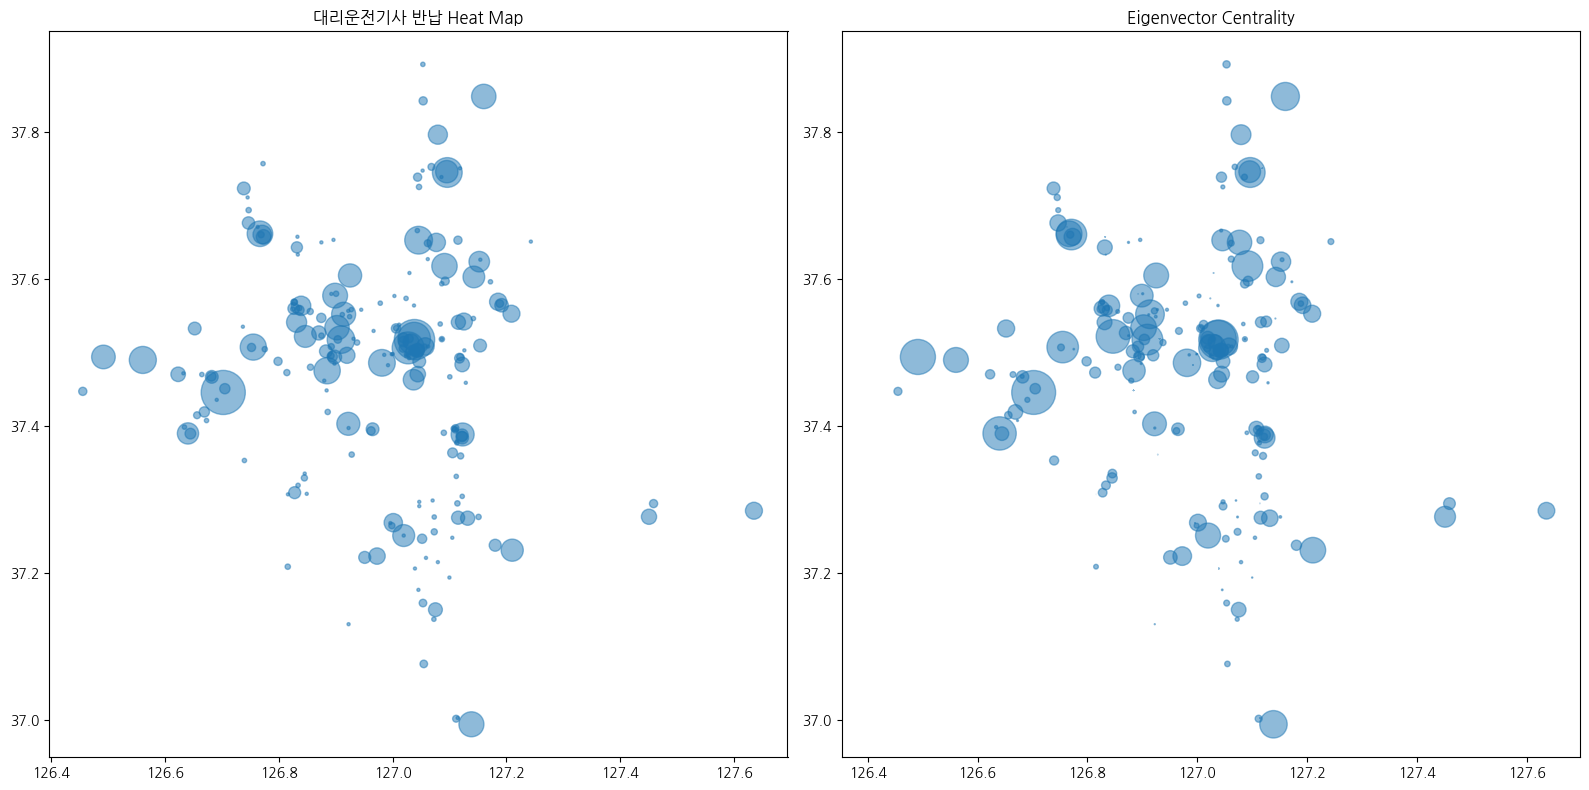

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))


# heat map for df_user_target
# visualization with scatter plot

ax[0].scatter(df_target_end_spot["x"], df_target_end_spot["y"], s = df_target_end_spot["count"]*5, alpha=0.5)
ax[0].set_title("대리운전기사 반납 Heat Map")
plt.title("대리운전기사 반납 Heat Map")

ax[1].scatter(df_ec["x"], df_ec["y"], s=df_ec["Eigenvector_centrality"] * 1000, alpha=0.5)
ax[1].set_title("Eigenvector Centrality")

plt.tight_layout()
plt.show()

In [ ]:
# visualization wiht folium with marker size via Eigenvector Centrality
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

for idx, row in df_ec.iterrows():
    folium.CircleMarker([row["y"], row["x"]], radius=row["Eigenvector_centrality"] * 10, color="blue", fill=True).add_to(m)

m.save("Data/PSAT_TOPIC2_Spot_Eigenvector_Centrality.html")

# Graph Clustering 

In [ ]:
from embedder import node_embedder
from sklearn.cluster import KMeans


G = nx.DiGraph()


model = node_embedder(G)

# by index to key, get only user nodes
node_idx = [i for i in range(len(model.wv.index_to_key))]
print(node_idx[:10])

for i, idx in enumerate(node_idx):
    print(model.wv.index_to_key[idx], end = ', ')
    if i == 10:
        break

node_embedding_vectors = model.wv.vectors[node_idx]

X = node_embedding_vectors
kmeans = KMeans(n_clusters=5, random_state=412).fit(X)
unique, counts = np.unique(kmeans.labels_, return_counts=True)